In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
import numpy as np
import matplotlib.pyplot as plt

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
"""def make_batch(input_data, noise_data, batch_size):
    index = np.arange(0, len(input_data))
    np.random.shuffle(index)
    index = index[:batch_size]
    shuffled_input_data = [input_data[i] for i in index]
    shuffled_noise_data = [noise_data[i] for i in index]
    
    return np.asarray(shuffled_input_data), np.asarray(shuffled_noise_data)"""
def make_batch(noise_data, batch_size):
    index = np.arange(0, len(noise_data))
    np.random.shuffle(index)
    index = index[:batch_size]
    shuffled_noise_data = [noise_data[i] for i in index]
    
    return np.asarray(shuffled_noise_data)
def make_noise_vector(batch_size, noise_size):
    noise_vector = np.random.normal(size=(batch_size, noise_size))
    return noise_vector

In [3]:
class GAN(object):
    def __init__(self, sess, batch_size):
        self.sess = sess
        self.batch_size = batch_size
        self.Noise_Input_Data_Size = 128#32
        self.Hidden_Layer1_Size_G = 256
        self.Hidden_Layer1_Size_D = 256
        self.Converted_Image_Size = 784
        self.parameter()
        self.model()
        
    def parameter(self):
        #input parameter
        self.X = tf.placeholder(dtype=tf.float32, shape=[None, self.Converted_Image_Size])
        self.Z = tf.placeholder(dtype=tf.float32, shape=[None, self.Noise_Input_Data_Size])
                
        #generator parameter
        self.W1_G = tf.Variable(tf.random_normal(dtype=tf.float32, shape=[self.Noise_Input_Data_Size, self.Hidden_Layer1_Size_G], stddev=0.01))
        self.b1_G = tf.Variable(tf.zeros(dtype=tf.float32, shape=[self.Hidden_Layer1_Size_G]))
        self.W2_G = tf.Variable(tf.random_normal(dtype=tf.float32, shape=[self.Hidden_Layer1_Size_G, self.Converted_Image_Size], stddev=0.01))
        
        #discriminator parameter
        self.W1_D = tf.Variable(tf.random_normal(dtype=tf.float32, shape=[self.Converted_Image_Size, self.Hidden_Layer1_Size_D], stddev=0.01))
        self.b1_D = tf.Variable(tf.zeros(dtype=tf.float32, shape=[self.Hidden_Layer1_Size_D]))
        self.W2_D = tf.Variable(tf.random_normal(dtype=tf.float32, shape=[self.Hidden_Layer1_Size_D, 1], stddev=0.01))
        
    def generator(self, noise):
        self.L1_G = tf.add(tf.matmul(noise, self.W1_G), self.b1_G)
        self.Y1_G = tf.nn.relu(self.L1_G)
        self.model_G = tf.nn.sigmoid(tf.matmul(self.Y1_G, self.W2_G))
                
        return self.model_G
    
    def discriminator(self, input_data):
        self.L1_D = tf.add(tf.matmul(input_data, self.W1_D), self.b1_D)
        self.Y1_D = tf.nn.relu(self.L1_D)
        self.model_D = tf.nn.sigmoid(tf.matmul(self.Y1_D, self.W2_D))
        
        return self.model_D
    
    def model(self):
        noise_data = make_noise_vector(self.batch_size, noise_size = self.Noise_Input_Data_Size)
        self.G = self.generator(self.Z)
        self.D_fake = self.discriminator(self.G)
        self.D_real = self.discriminator(self.X)
        
        D_var_list = [self.W1_D, self.b1_D, self.W2_D]
        G_var_list = [self.W1_G, self.b1_G, self.W2_G]
        
        self.cost_D = tf.reduce_mean(tf.log(self.D_real) + tf.log(1-self.D_fake))#maximize
        self.Optimize_D = tf.train.AdamOptimizer(learning_rate=0.002).minimize(-self.cost_D, var_list = D_var_list)
        #self.Optimize_D = tf.train.AdamOptimizer(learning_rate=0.001).minimize(-self.cost_D)
        #self.cost_G = tf.reduce_mean(tf.log(self.D_real))#maximize
        self.cost_G = tf.reduce_mean(tf.log(1-self.D_fake))#minimize
        self.Optimize_G = tf.train.AdamOptimizer(learning_rate=0.002).minimize(self.cost_G, var_list = G_var_list)
        #self.Optimize_G = tf.train.AdamOptimizer(learning_rate=0.001).minimize(-self.cost_G)
        
    def training(self):
        data_size = 55000
        
        total_batch = int(data_size / self.batch_size)
        #SAVE_PATH = "C:/Users/JAEKYU/Documents/Jupyter Notebook/Super_Resolution_/Weight/Weight.ckpt"

        print("Session start")
        self.sess.run(tf.global_variables_initializer())
        for epoch in range(40):
            for i in range(total_batch):
                #batch 만들기
                batch_X = mnist.train.next_batch(batch_size=self.batch_size)[0]#32,784
                batch_Z = make_batch(make_noise_vector(self.batch_size, self.Noise_Input_Data_Size), self.batch_size)#32,10
                #print("batch 생성 end")
                #session run
                #print("sesstion run start")
                Opt_G, cost_G = self.sess.run([self.Optimize_G, self.cost_G], feed_dict={self.Z : batch_Z})
                Opt_D, cost_D = self.sess.run([self.Optimize_D, self.cost_D], feed_dict={self.X : batch_X, self.Z : batch_Z})
                #print("sesstion run sucess")
            print("epoch : ", epoch, ", gen_cost : ", cost_G, ", dis_cost : ", cost_D)
            
            

            if(epoch%10 == 0):
                noise_data = make_batch(make_noise_vector(self.batch_size, self.Noise_Input_Data_Size), self.batch_size)
                samples = self.sess.run(self.G, feed_dict={self.Z : noise_data})
                fig, ax = plt.subplots(1, self.batch_size, figsize=(self.batch_size, 1))
                for j in range(self.batch_size):
                    ax[j].set_axis_off()
                    ax[j].imshow(np.reshape(samples[j], (28, 28)))
                fig.show()
                plt.draw()
                plt.show()
                

            

Session start
epoch :  0 , gen_cost :  -0.0034328087 , dis_cost :  -0.02583955


C:\Users\JAEKYU\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


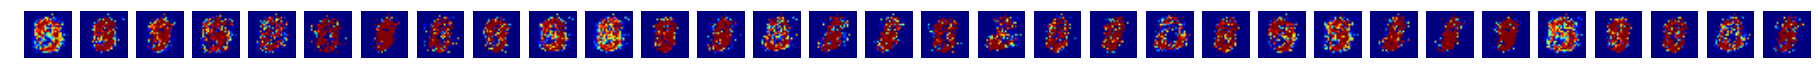

epoch :  1 , gen_cost :  -0.00011243635 , dis_cost :  -0.0009817013
epoch :  2 , gen_cost :  -0.00025693665 , dis_cost :  -0.00035281078
epoch :  3 , gen_cost :  -0.03641541 , dis_cost :  -0.22637057
epoch :  4 , gen_cost :  -0.083256476 , dis_cost :  -0.2655037
epoch :  5 , gen_cost :  -0.11611982 , dis_cost :  -0.3039512
epoch :  6 , gen_cost :  -0.35635662 , dis_cost :  -0.5425571
epoch :  7 , gen_cost :  -0.24457438 , dis_cost :  -0.96618044
epoch :  8 , gen_cost :  -0.44103396 , dis_cost :  -1.0231154
epoch :  9 , gen_cost :  -0.308468 , dis_cost :  -0.98509204
epoch :  10 , gen_cost :  -0.18556364 , dis_cost :  -0.5253457


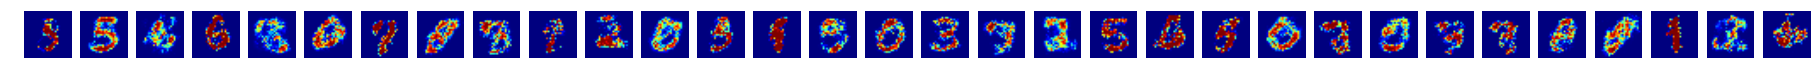

epoch :  11 , gen_cost :  -0.42763284 , dis_cost :  -0.8148427
epoch :  12 , gen_cost :  -0.14001617 , dis_cost :  -0.4860886
epoch :  13 , gen_cost :  -0.18505508 , dis_cost :  -0.90539634
epoch :  14 , gen_cost :  -0.50799763 , dis_cost :  -1.1284916
epoch :  15 , gen_cost :  -0.29690892 , dis_cost :  -0.8425361
epoch :  16 , gen_cost :  -0.2040832 , dis_cost :  -0.64800763
epoch :  17 , gen_cost :  -0.49854094 , dis_cost :  -0.9697992
epoch :  18 , gen_cost :  -0.40519544 , dis_cost :  -0.8001764
epoch :  19 , gen_cost :  -0.3932995 , dis_cost :  -0.7485086
epoch :  20 , gen_cost :  -0.35137963 , dis_cost :  -0.79082686


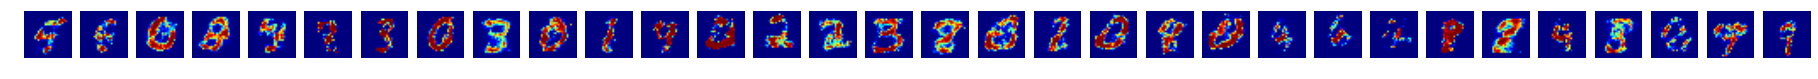

epoch :  21 , gen_cost :  -0.33807173 , dis_cost :  -1.1949371
epoch :  22 , gen_cost :  -0.22280242 , dis_cost :  -1.0082932
epoch :  23 , gen_cost :  -0.36440533 , dis_cost :  -0.89603585
epoch :  24 , gen_cost :  -0.45287415 , dis_cost :  -1.0210083
epoch :  25 , gen_cost :  -0.30483156 , dis_cost :  -0.8642447
epoch :  26 , gen_cost :  -0.20062914 , dis_cost :  -0.662765
epoch :  27 , gen_cost :  -0.7426609 , dis_cost :  -1.175876
epoch :  28 , gen_cost :  -0.3056411 , dis_cost :  -0.66994643
epoch :  29 , gen_cost :  -0.39764488 , dis_cost :  -0.6894691
epoch :  30 , gen_cost :  -0.38189614 , dis_cost :  -0.8416096


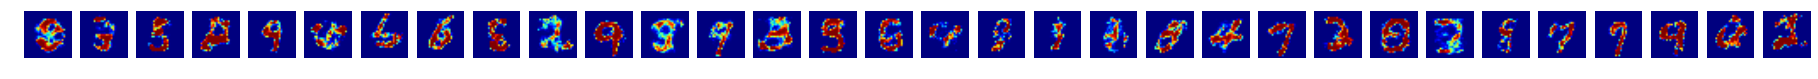

epoch :  31 , gen_cost :  -0.27165934 , dis_cost :  -0.76922077
epoch :  32 , gen_cost :  -0.26470625 , dis_cost :  -0.7852204
epoch :  33 , gen_cost :  -0.31998426 , dis_cost :  -0.7018801
epoch :  34 , gen_cost :  -0.13726364 , dis_cost :  -0.635165
epoch :  35 , gen_cost :  -0.24746081 , dis_cost :  -0.8978145
epoch :  36 , gen_cost :  -0.7920655 , dis_cost :  -1.1757419
epoch :  37 , gen_cost :  -0.46640337 , dis_cost :  -0.838202
epoch :  38 , gen_cost :  -0.39847004 , dis_cost :  -0.85366124
epoch :  39 , gen_cost :  -0.53094876 , dis_cost :  -1.0497267


In [4]:
with tf.Session() as sess:
    GAN_object = GAN(sess, batch_size = 32)
    GAN_object.training()

In [5]:
np.shape(mnist.train.images)

(55000, 784)

In [76]:
np.shape(mnist.test.images)

(10000, 784)

In [17]:
batch_X = mnist.train.next_batch(batch_size=32)[0]
batch_Z = make_noise_vector(32, 10)

In [18]:
print(np.shape(batch_X))
print(np.shape(batch_Z))

(32, 784)
(32, 10)


In [36]:
# 2016년에 가장 관심을 많이 받았던 비감독(Unsupervised) 학습 방법인
# Generative Adversarial Network(GAN)을 구현해봅니다.
# https://arxiv.org/abs/1406.2661
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

#########
# 옵션 설정
######
total_epoch = 100
batch_size = 100
learning_rate = 0.0002
# 신경망 레이어 구성 옵션
n_hidden = 256
n_input = 28 * 28
n_noise = 128  # 생성기의 입력값으로 사용할 노이즈의 크기

#########
# 신경망 모델 구성
######
# GAN 도 Unsupervised 학습이므로 Autoencoder 처럼 Y 를 사용하지 않습니다.
X = tf.placeholder(tf.float32, [None, n_input])
# 노이즈 Z를 입력값으로 사용합니다.
Z = tf.placeholder(tf.float32, [None, n_noise])

# 생성기 신경망에 사용하는 변수들입니다.
G_W1 = tf.Variable(tf.random_normal([n_noise, n_hidden], stddev=0.01))
G_b1 = tf.Variable(tf.zeros([n_hidden]))
G_W2 = tf.Variable(tf.random_normal([n_hidden, n_input], stddev=0.01))
G_b2 = tf.Variable(tf.zeros([n_input]))

# 판별기 신경망에 사용하는 변수들입니다.
D_W1 = tf.Variable(tf.random_normal([n_input, n_hidden], stddev=0.01))
D_b1 = tf.Variable(tf.zeros([n_hidden]))
# 판별기의 최종 결과값은 얼마나 진짜와 가깝냐를 판단하는 한 개의 스칼라값입니다.
D_W2 = tf.Variable(tf.random_normal([n_hidden, 1], stddev=0.01))
D_b2 = tf.Variable(tf.zeros([1]))


# 생성기(G) 신경망을 구성합니다.
def generator(noise_z):
    hidden = tf.nn.relu(
                    tf.matmul(noise_z, G_W1) + G_b1)
    output = tf.nn.sigmoid(
                    tf.matmul(hidden, G_W2) + G_b2)

    return output


# 판별기(D) 신경망을 구성합니다.
def discriminator(inputs):
    hidden = tf.nn.relu(
                    tf.matmul(inputs, D_W1) + D_b1)
    output = tf.nn.sigmoid(
                    tf.matmul(hidden, D_W2) + D_b2)

    return output


# 랜덤한 노이즈(Z)를 만듭니다.
def get_noise(batch_size, n_noise):
    return np.random.normal(size=(batch_size, n_noise))


# 노이즈를 이용해 랜덤한 이미지를 생성합니다.
G = generator(Z)
# 노이즈를 이용해 생성한 이미지가 진짜 이미지인지 판별한 값을 구합니다.
D_gene = discriminator(G)
# 진짜 이미지를 이용해 판별한 값을 구합니다.
D_real = discriminator(X)

# 논문에 따르면, GAN 모델의 최적화는 loss_G 와 loss_D 를 최대화 하는 것 입니다.
# 다만 loss_D와 loss_G는 서로 연관관계가 있기 때문에 두 개의 손실값이 항상 같이 증가하는 경향을 보이지는 않을 것 입니다.
# loss_D가 증가하려면 loss_G는 하락해야하고, loss_G가 증가하려면 loss_D는 하락해야하는 경쟁관계에 있기 때문입니다.
# 논문의 수식에 따른 다음 로직을 보면 loss_D 를 최대화하기 위해서는 D_gene 값을 최소화하게 됩니다.
# 판별기에 진짜 이미지를 넣었을 때에도 최대값을 : tf.log(D_real)
# 가짜 이미지를 넣었을 때에도 최대값을 : tf.log(1 - D_gene)
# 갖도록 학습시키기 때문입니다.
# 이것은 판별기는 생성기가 만들어낸 이미지가 가짜라고 판단하도록 판별기 신경망을 학습시킵니다.
loss_D = tf.reduce_mean(tf.log(D_real) + tf.log(1 - D_gene))
# 반면 loss_G 를 최대화하기 위해서는 D_gene 값을 최대화하게 되는데,
# 이것은 가짜 이미지를 넣었을 때, 판별기가 최대한 실제 이미지라고 판단하도록 생성기 신경망을 학습시킵니다.
# 논문에서는 loss_D 와 같은 수식으로 최소화 하는 생성기를 찾지만,
# 결국 D_gene 값을 최대화하는 것이므로 다음과 같이 사용할 수 있습니다.
loss_G = tf.reduce_mean(tf.log(D_gene))

# loss_D 를 구할 때는 판별기 신경망에 사용되는 변수만 사용하고,
# loss_G 를 구할 때는 생성기 신경망에 사용되는 변수만 사용하여 최적화를 합니다.
D_var_list = [D_W1, D_b1, D_W2, D_b2]
G_var_list = [G_W1, G_b1, G_W2, G_b2]

# GAN 논문의 수식에 따르면 loss 를 극대화 해야하지만, minimize 하는 최적화 함수를 사용하기 때문에
# 최적화 하려는 loss_D 와 loss_G 에 음수 부호를 붙여줍니다.
train_D = tf.train.AdamOptimizer(learning_rate).minimize(-loss_D,
                                                         var_list=D_var_list)
train_G = tf.train.AdamOptimizer(learning_rate).minimize(-loss_G,
                                                         var_list=G_var_list)

#########
# 신경망 모델 학습
######
sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = int(mnist.train.num_examples/batch_size)
loss_val_D, loss_val_G = 0, 0

for epoch in range(total_epoch):
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        noise = get_noise(batch_size, n_noise)

        # 판별기와 생성기 신경망을 각각 학습시킵니다.
        _, loss_val_D = sess.run([train_D, loss_D],
                                 feed_dict={X: batch_xs, Z: noise})
        _, loss_val_G = sess.run([train_G, loss_G],
                                 feed_dict={Z: noise})

    print('Epoch:', '%04d' % epoch,
          'D loss: {:.4}'.format(loss_val_D),
          'G loss: {:.4}'.format(loss_val_G))

    #########
    # 학습이 되어가는 모습을 보기 위해 주기적으로 이미지를 생성하여 저장
    ######
    if epoch == 0 or (epoch + 1) % 10 == 0:
        sample_size = 10
        noise = get_noise(sample_size, n_noise)
        samples = sess.run(G, feed_dict={Z: noise})

        fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1))

        for i in range(sample_size):
            ax[i].set_axis_off()
            ax[i].imshow(np.reshape(samples[i], (28, 28)))

        #plt.savefig('samples/{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
        #plt.close(fig)

print('최적화 완료!')

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Epoch: 0000 D loss: -0.4481 G loss: -2.109
Epoch: 0001 D loss: -0.4841 G loss: -2.083
Epoch: 0002 D loss: -0.3754 G loss: -2.139
Epoch: 0003 D loss: -0.365 G loss: -1.749
Epoch: 0004 D loss: -0.2721 G loss: -2.577
Epoch: 0005 D loss: -0.1336 G loss: -3.004
Epoch: 0006 D loss: -0.1662 G loss: -3.106
Epoch: 0007 D loss: -0.1727 G loss: -2.787
Epoch: 0008 D loss: -0.4305 G loss: -2.6
Epoch: 0009 D loss: -0.4846 G loss: -2.11
Epoch: 0010 D loss: -0.3476 G loss: -2.608
Epoch: 0011 D loss: -0.6187 G loss: -1.955


KeyboardInterrupt: 